### Generate Data-based Figures and Diagrams for PeerJ Paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from modules import prepared_data

# controls
save_figs = True
plt.rcParams['figure.dpi'] = 500

In [2]:
FSL_dataset = np.load(f'FSL_alphabet_landmarks_24classes.npy', allow_pickle=True).item()
num_data = len(FSL_dataset['target'])
print(f'{num_data} data points collected. Each datapoint represents the MediaPipe landmarks of the hand.')

10800 data points collected. Each datapoint represents the MediaPipe landmarks of the hand.


#### Frequency of Converted Images into Landmarks

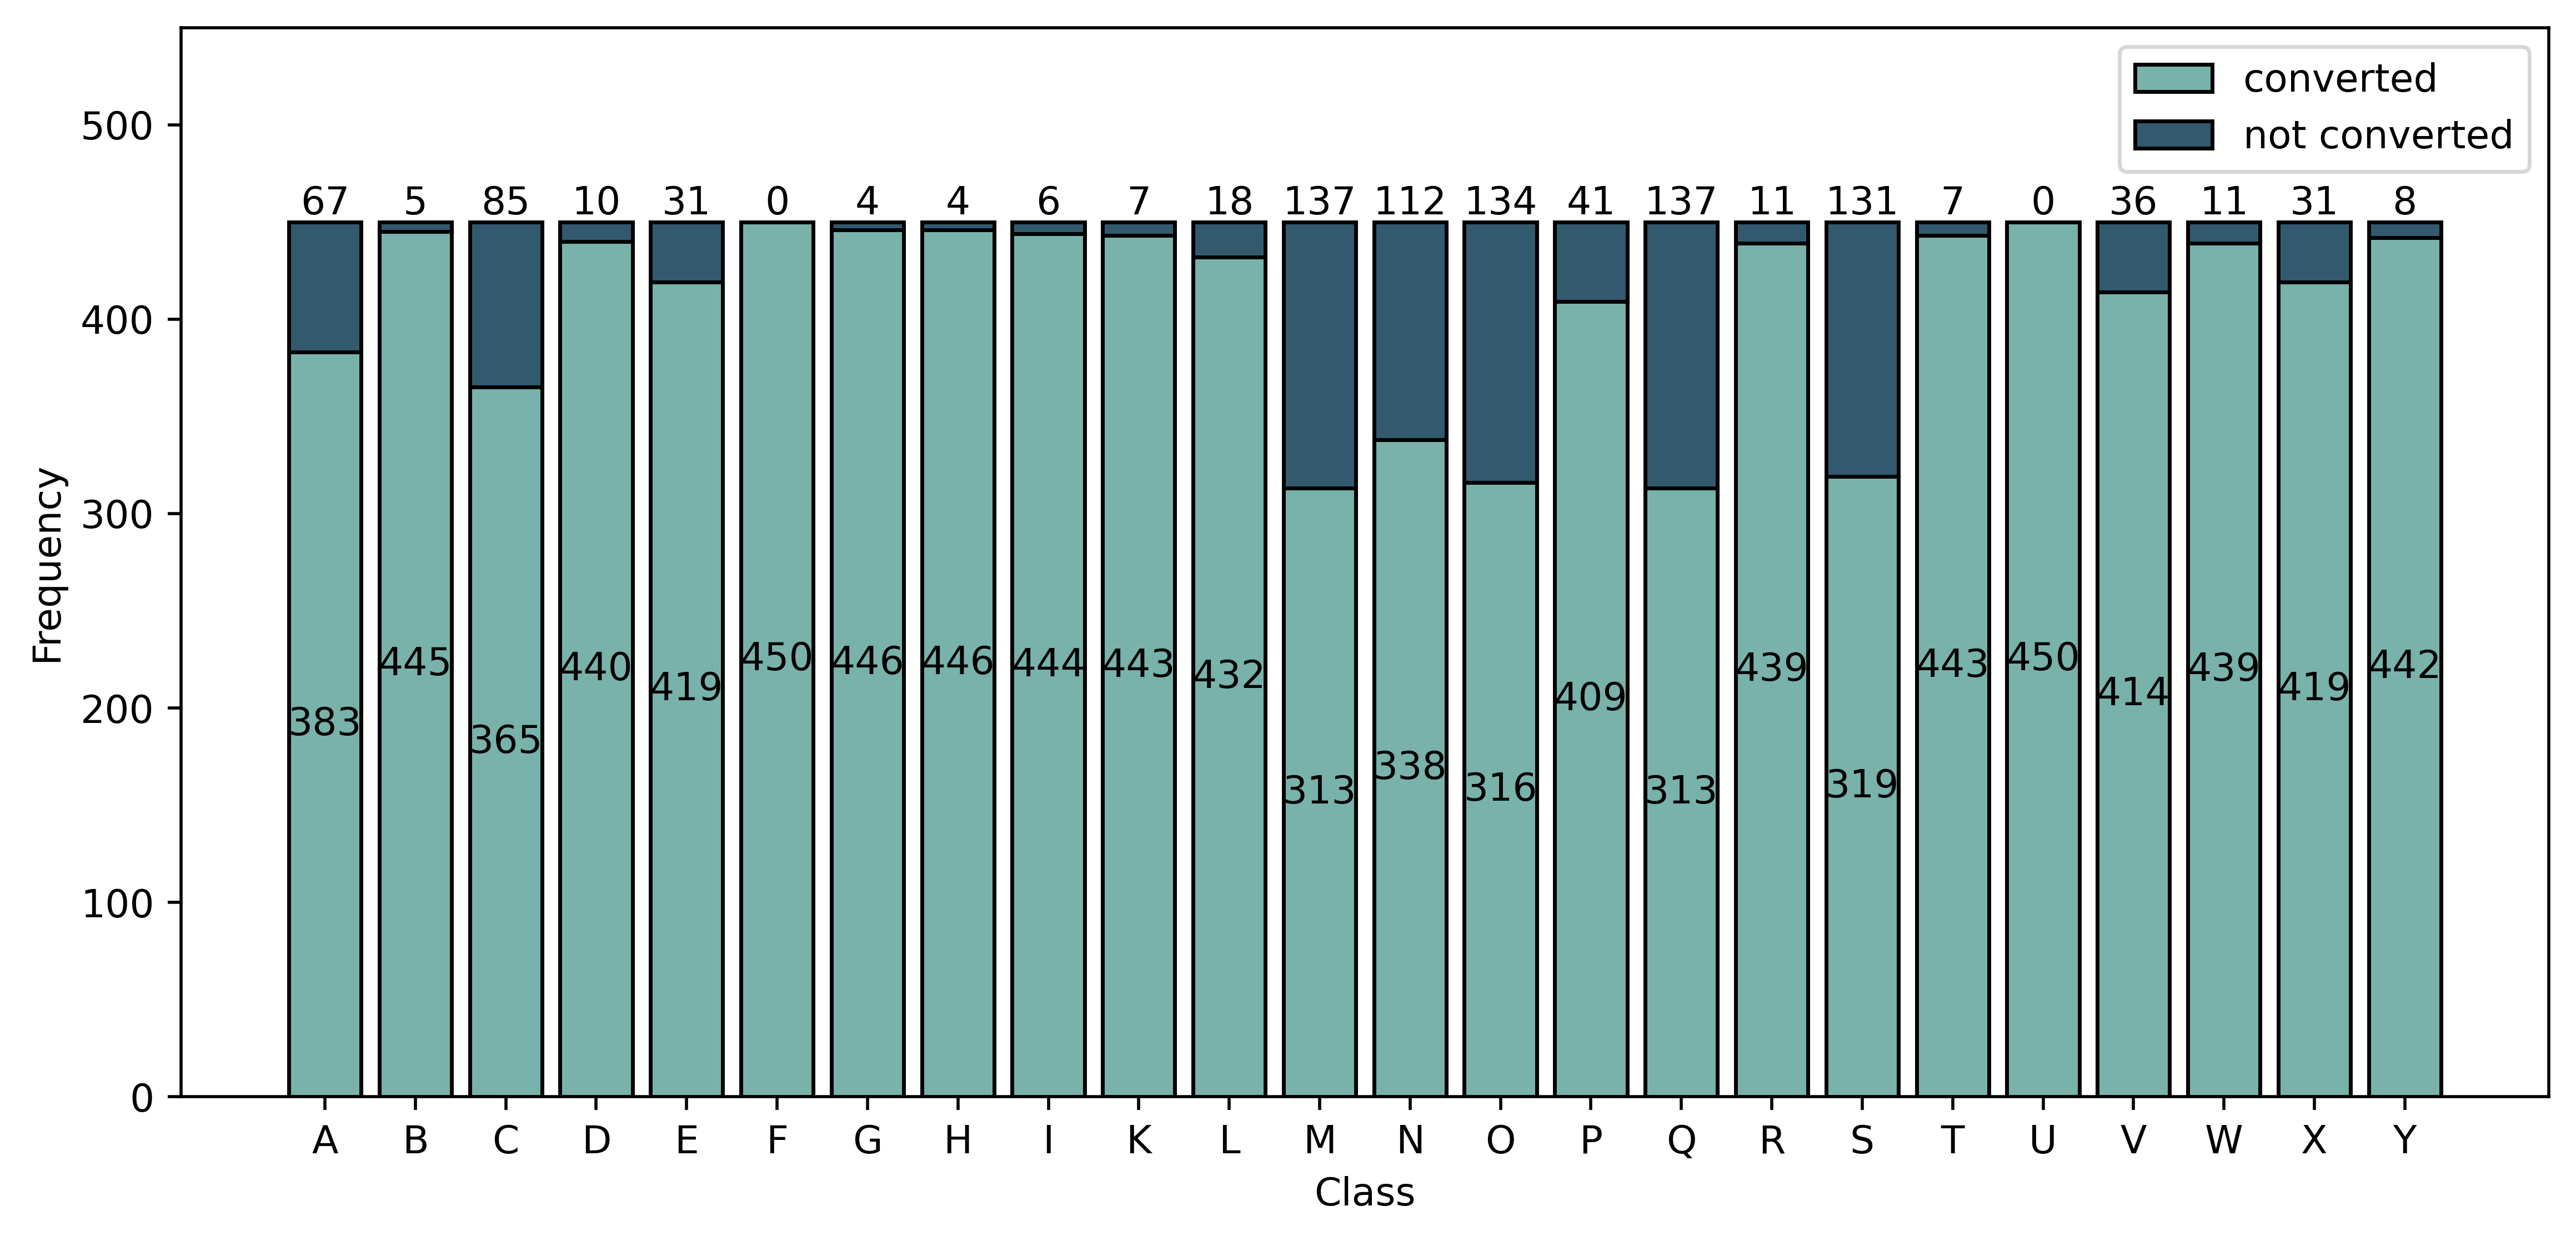

In [3]:
# indices of None values
none_idx = np.array([idx for idx,data in enumerate(FSL_dataset['data']) if data is None])
none_targets = np.array(FSL_dataset['target'])[none_idx]

# remark: All instances with class "F" and "U" have landmarks
unique, frequency = np.unique(none_targets, return_counts=True)
unique = np.insert(unique, [5, -4], ['F', 'U'])
frequency = np.insert(frequency, [5, -4], 0)

frequency = {"converted": np.full_like(frequency, 450) - frequency,
             "not converted": frequency}
colors = ["#78b2ab", "#33596f"]
labels = list(frequency.keys())
l_type = ["center", "edge"]
bottom = np.zeros_like(frequency["converted"])


plt.figure(figsize=(11, 5))
for idx, freq in enumerate(frequency.values()):
    b = plt.bar(np.arange(len(freq)), freq, color=colors[idx], edgecolor='k',
                bottom=bottom, tick_label=unique)
    plt.bar_label(b, labels=frequency[labels[idx]], label_type=l_type[idx])
    bottom += freq

plt.ylim([0, 550])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.legend(["converted", "not converted"], loc="upper right")
plt.savefig("figures/result_converted.png")
plt.show()

#### Scaled and Unscaled Dataset

In [4]:
# balanced dataset
X_bal, y_bal, paths_bal = prepared_data(FSL_dataset, balanced=True, random_state=21)
print(f"""Balanced dataset prepared.
        total num_instances                 : {X_bal.shape[0]}
        num_instances per class             : {X_bal.shape[0]/24:n}
        num_features                        : {X_bal.shape[1]}""")

Balanced dataset prepared.
        total num_instances                 : 7512
        num_instances per class             : 313
        num_features                        : 63


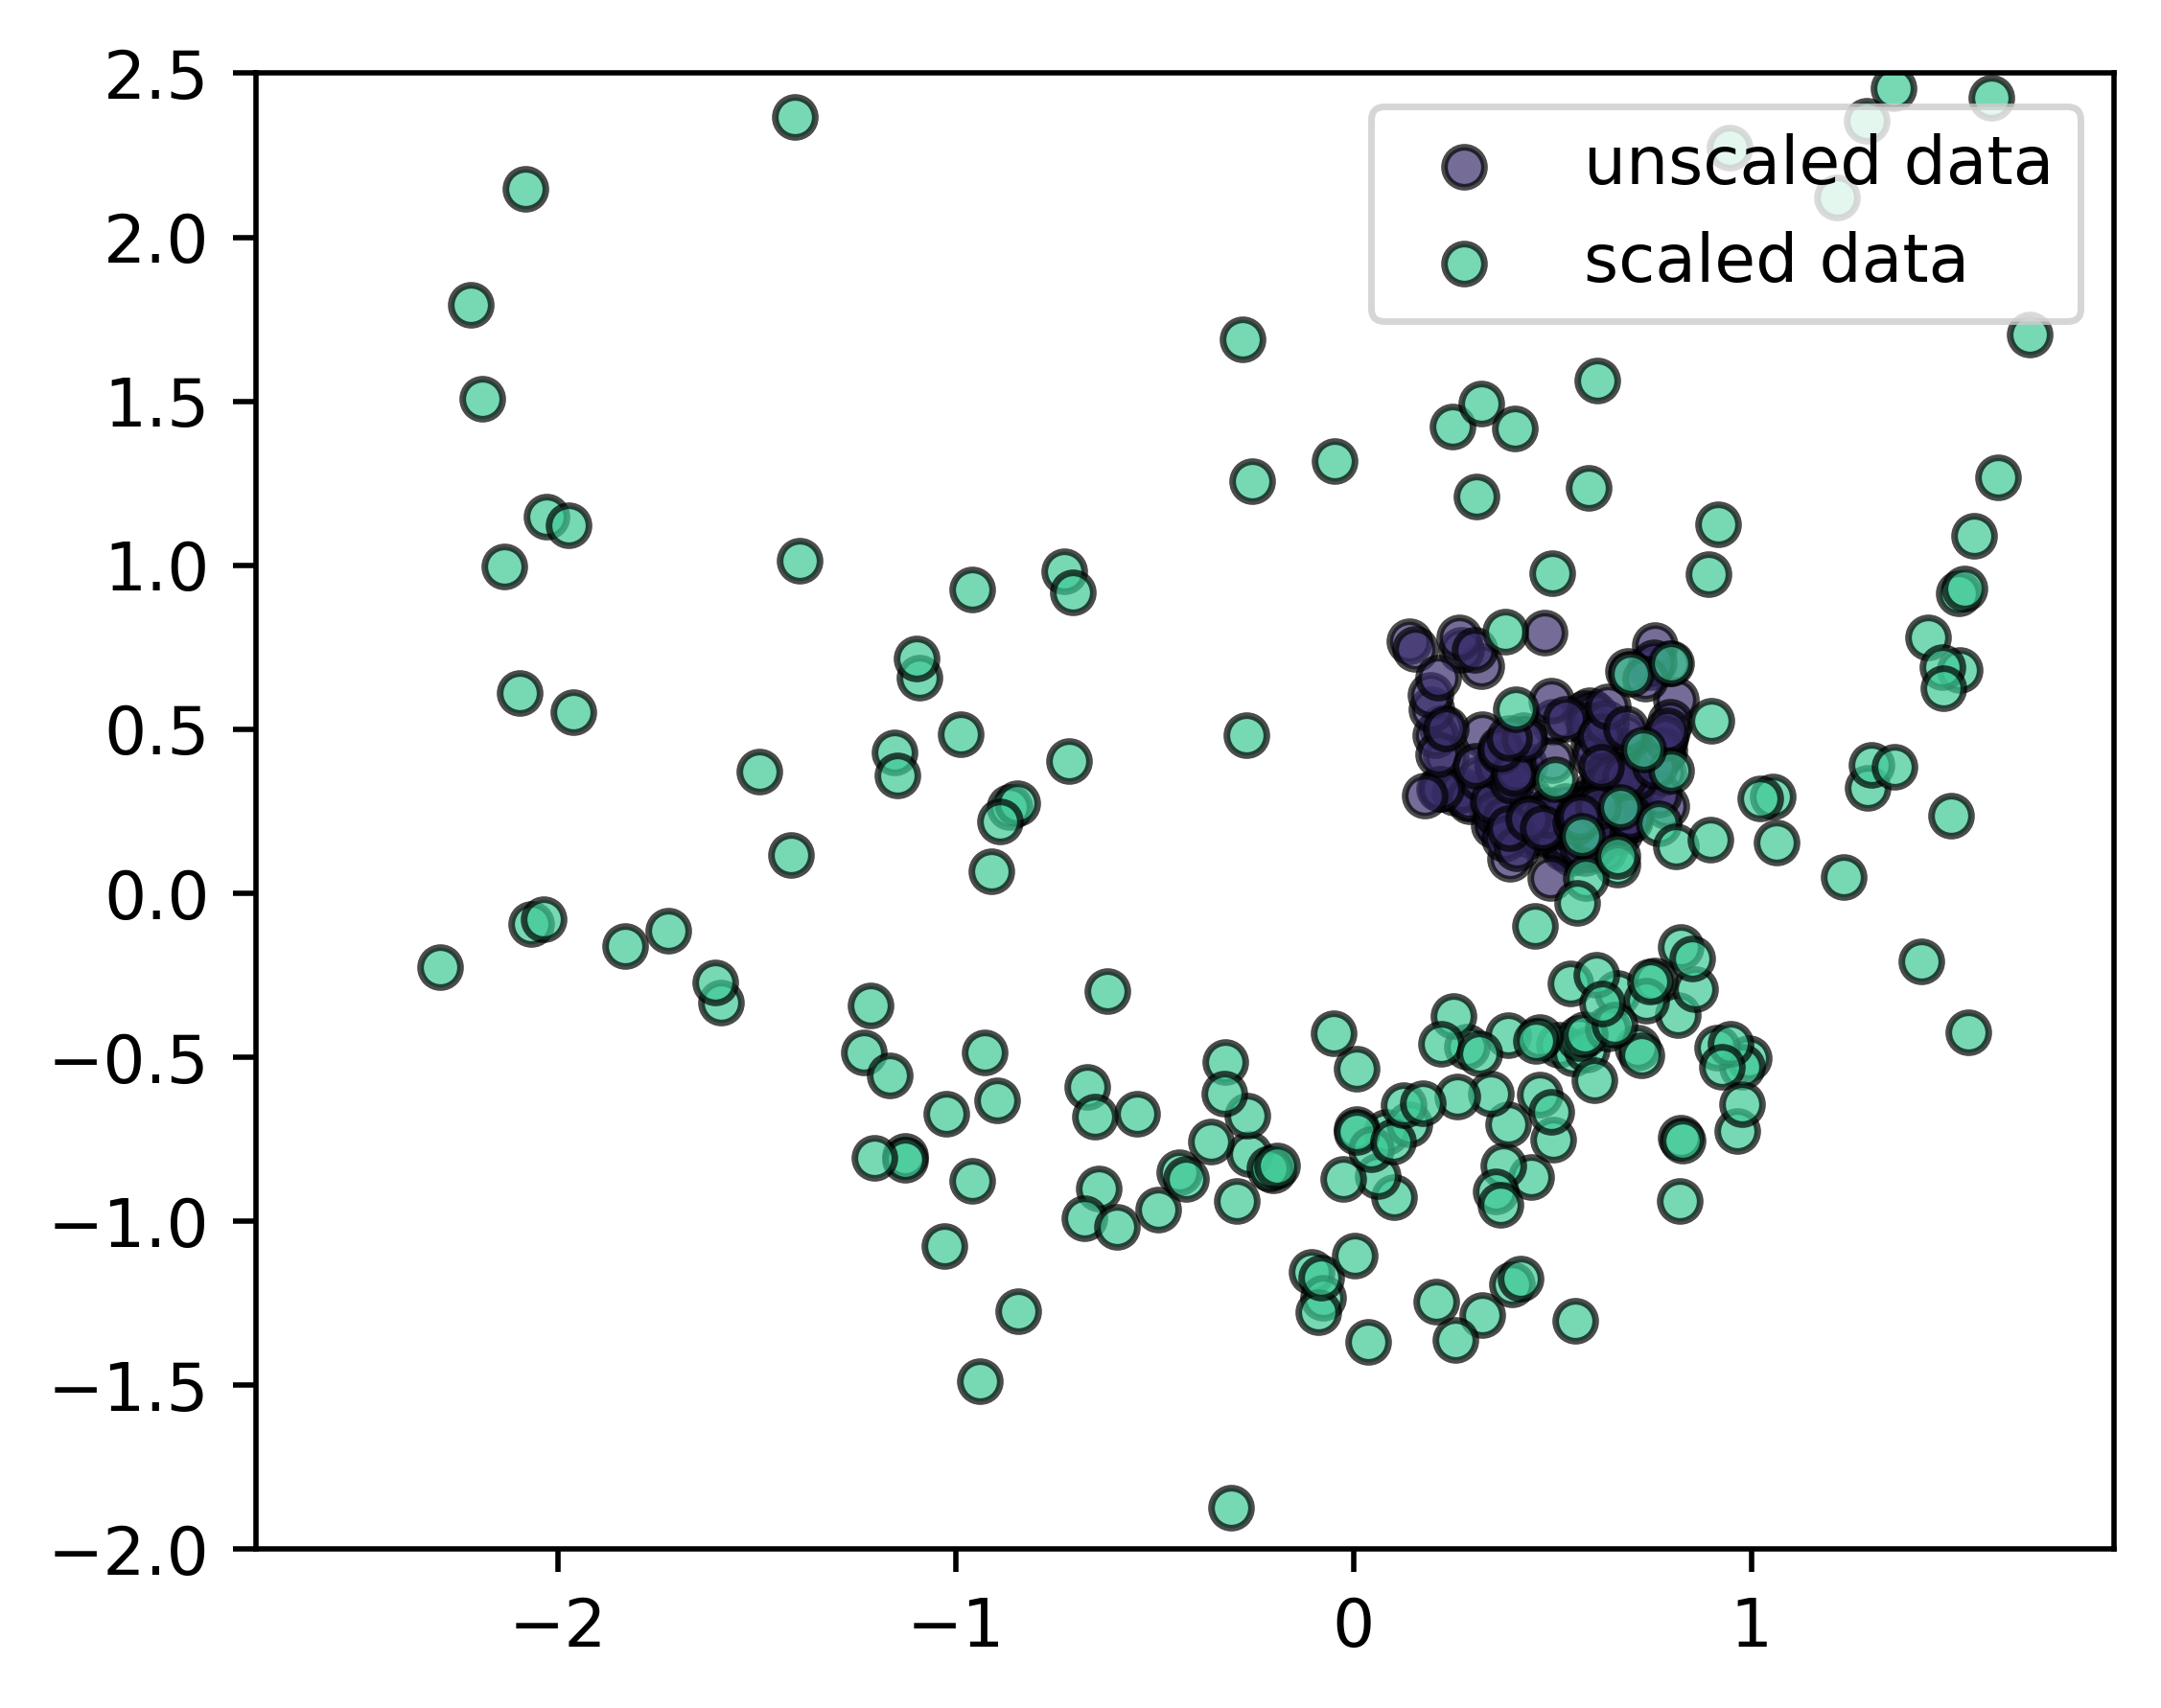

In [5]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.10, stratify=y_bal, random_state=21)
unscaled = X_train_bal.copy()
scaled = StandardScaler().fit_transform(unscaled)

n = 21  # feature index
num_pts = 200  # number of instances in plot
unscaled = unscaled[:num_pts, n:n+2]
scaled = scaled[:num_pts, n:n+2]

# plot aesthetics
alpha = 0.7
plt.rcParams['scatter.edgecolors'] = 'k'

# plotting points
fig = plt.figure(figsize=(5,4))
plt.scatter(unscaled[:,0], 
               unscaled[:,1], 
               alpha=alpha, c="#3a2f6b",
               label='unscaled data')
plt.scatter(scaled[:,0], 
               scaled[:,1], c="#3ec995", 
               alpha=alpha, label='scaled data')

plt.legend(loc="upper right")
plt.ylim([-2, 2.5])
if save_figs:
    plt.savefig('figures/scaled_unscaled_data.png')
plt.show()


#### Image and Landmarks

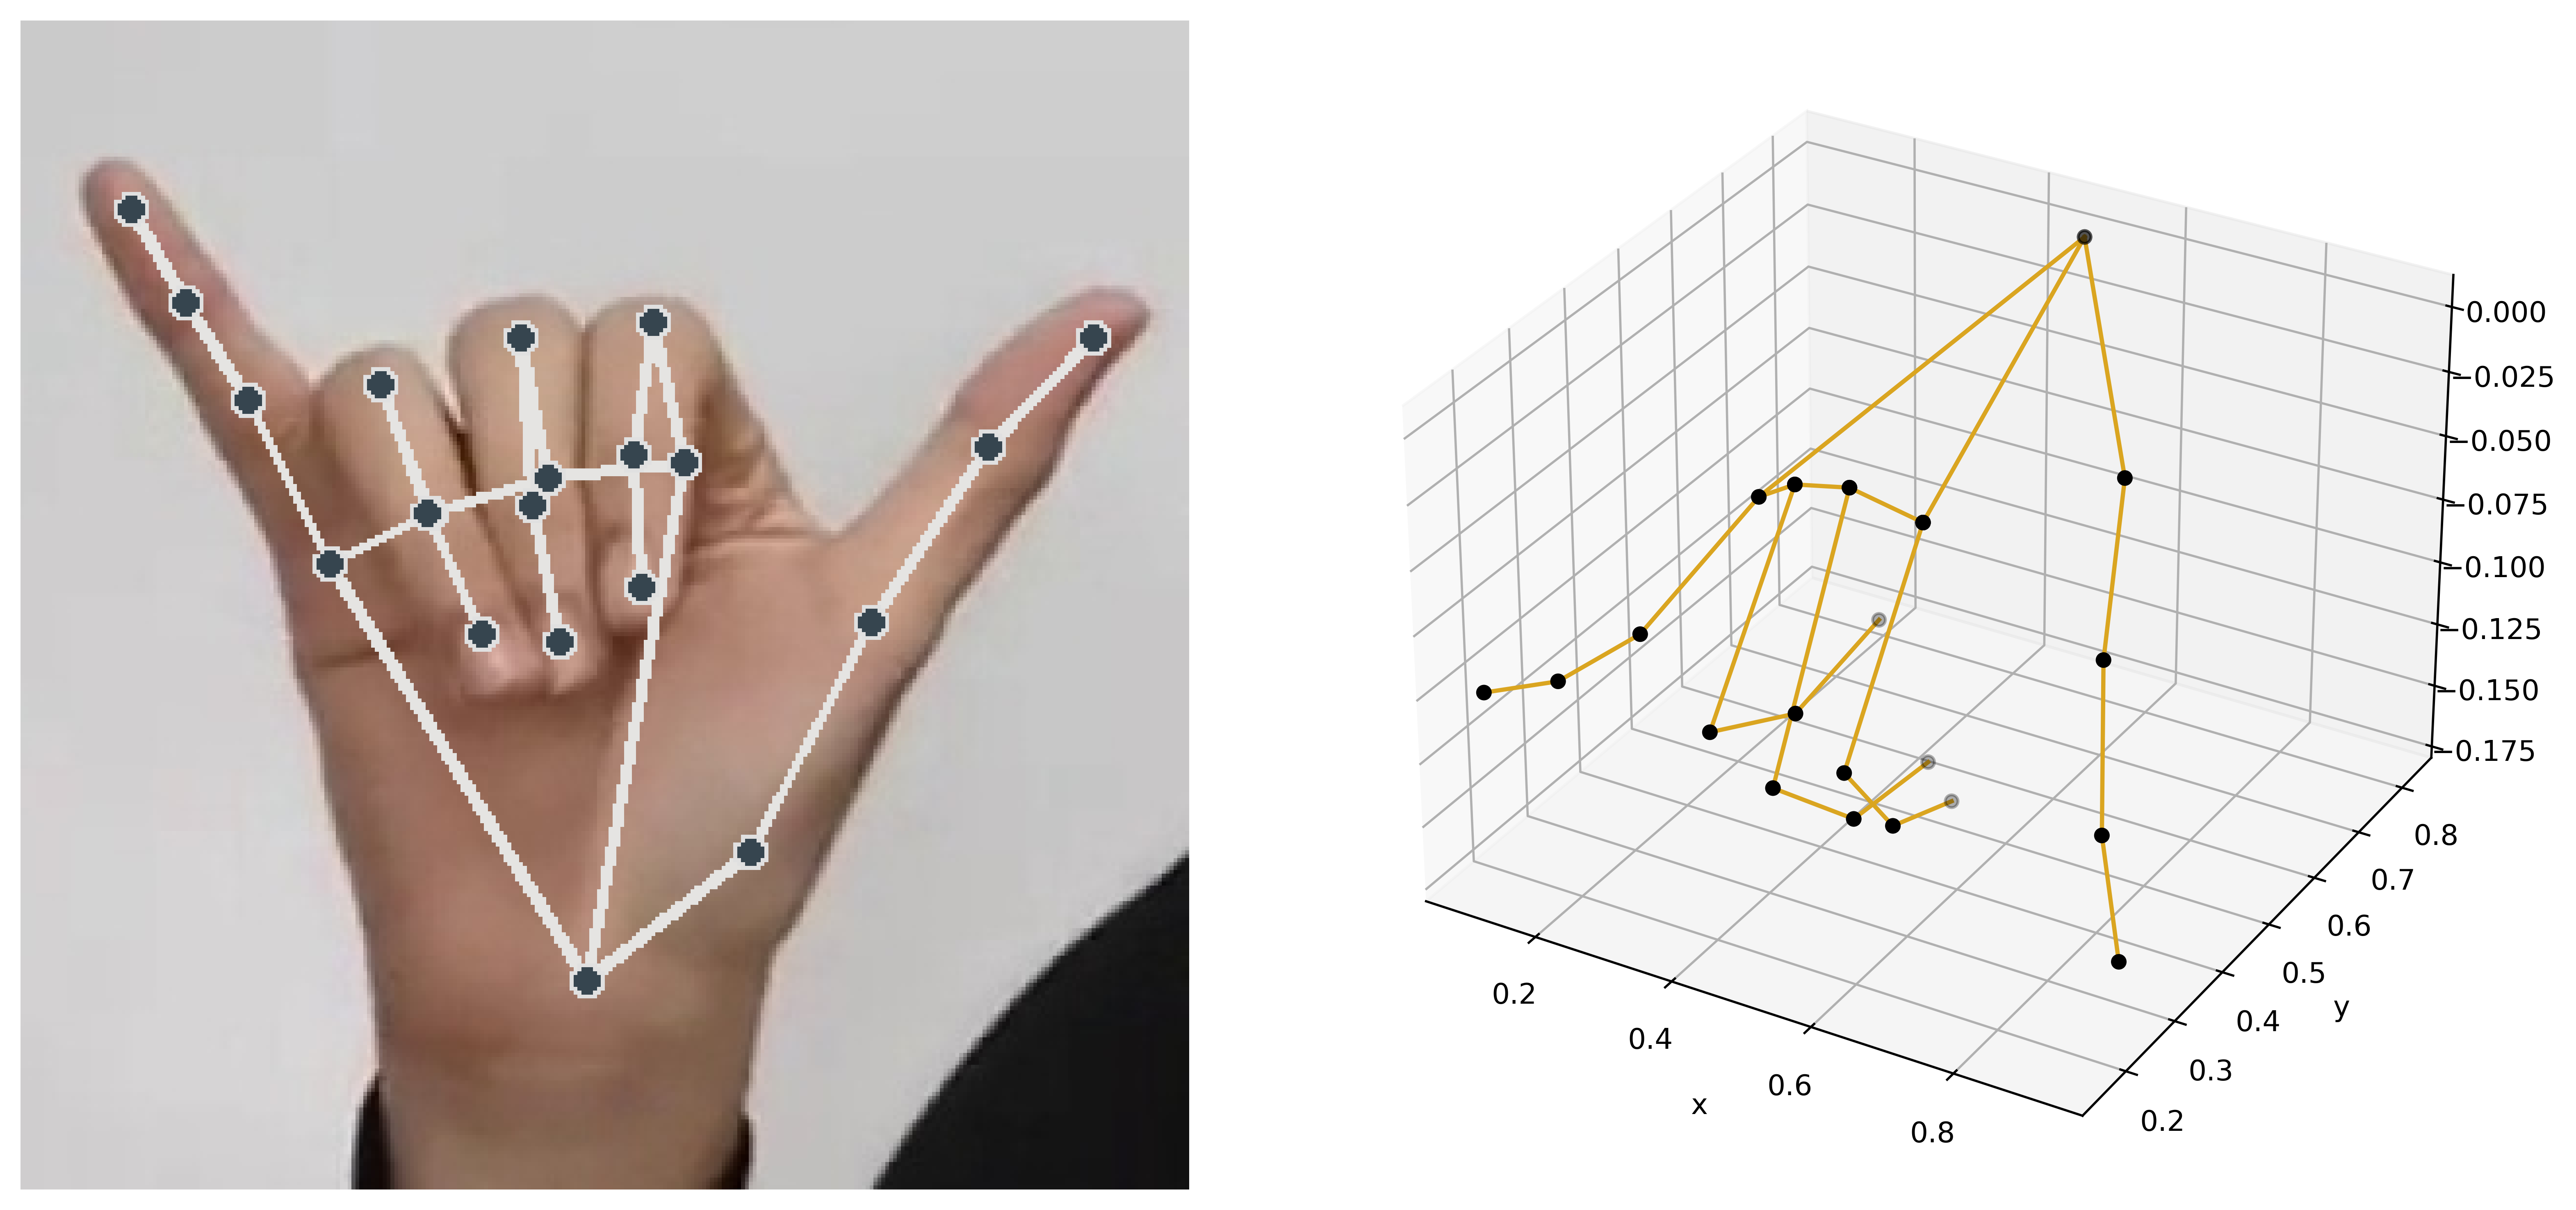

In [6]:
from modules import Image2Landmarks

img_path = 'FSL_images/Y/276.jpg'
img2landmarks = Image2Landmarks(flatten=True, display_image=True, display_landmarks=True, save_figs=True)
landmarks = img2landmarks.image_to_hand_landmarks(image_path=img_path, figure_size=(13, 6))

#### Main Results 

In [7]:
from modules import plot_boxplots, plot_bars
import matplotlib.pyplot as plt

# plot controls
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12

predicted_labels_balanced = np.load("predicted_labels_balanced.npy", allow_pickle=True).item()
predicted_labels_imbalanced = np.load("predicted_labels_imbalanced.npy", allow_pickle=True).item()

print("Predicted labels are extracted.")

Predicted labels are extracted.


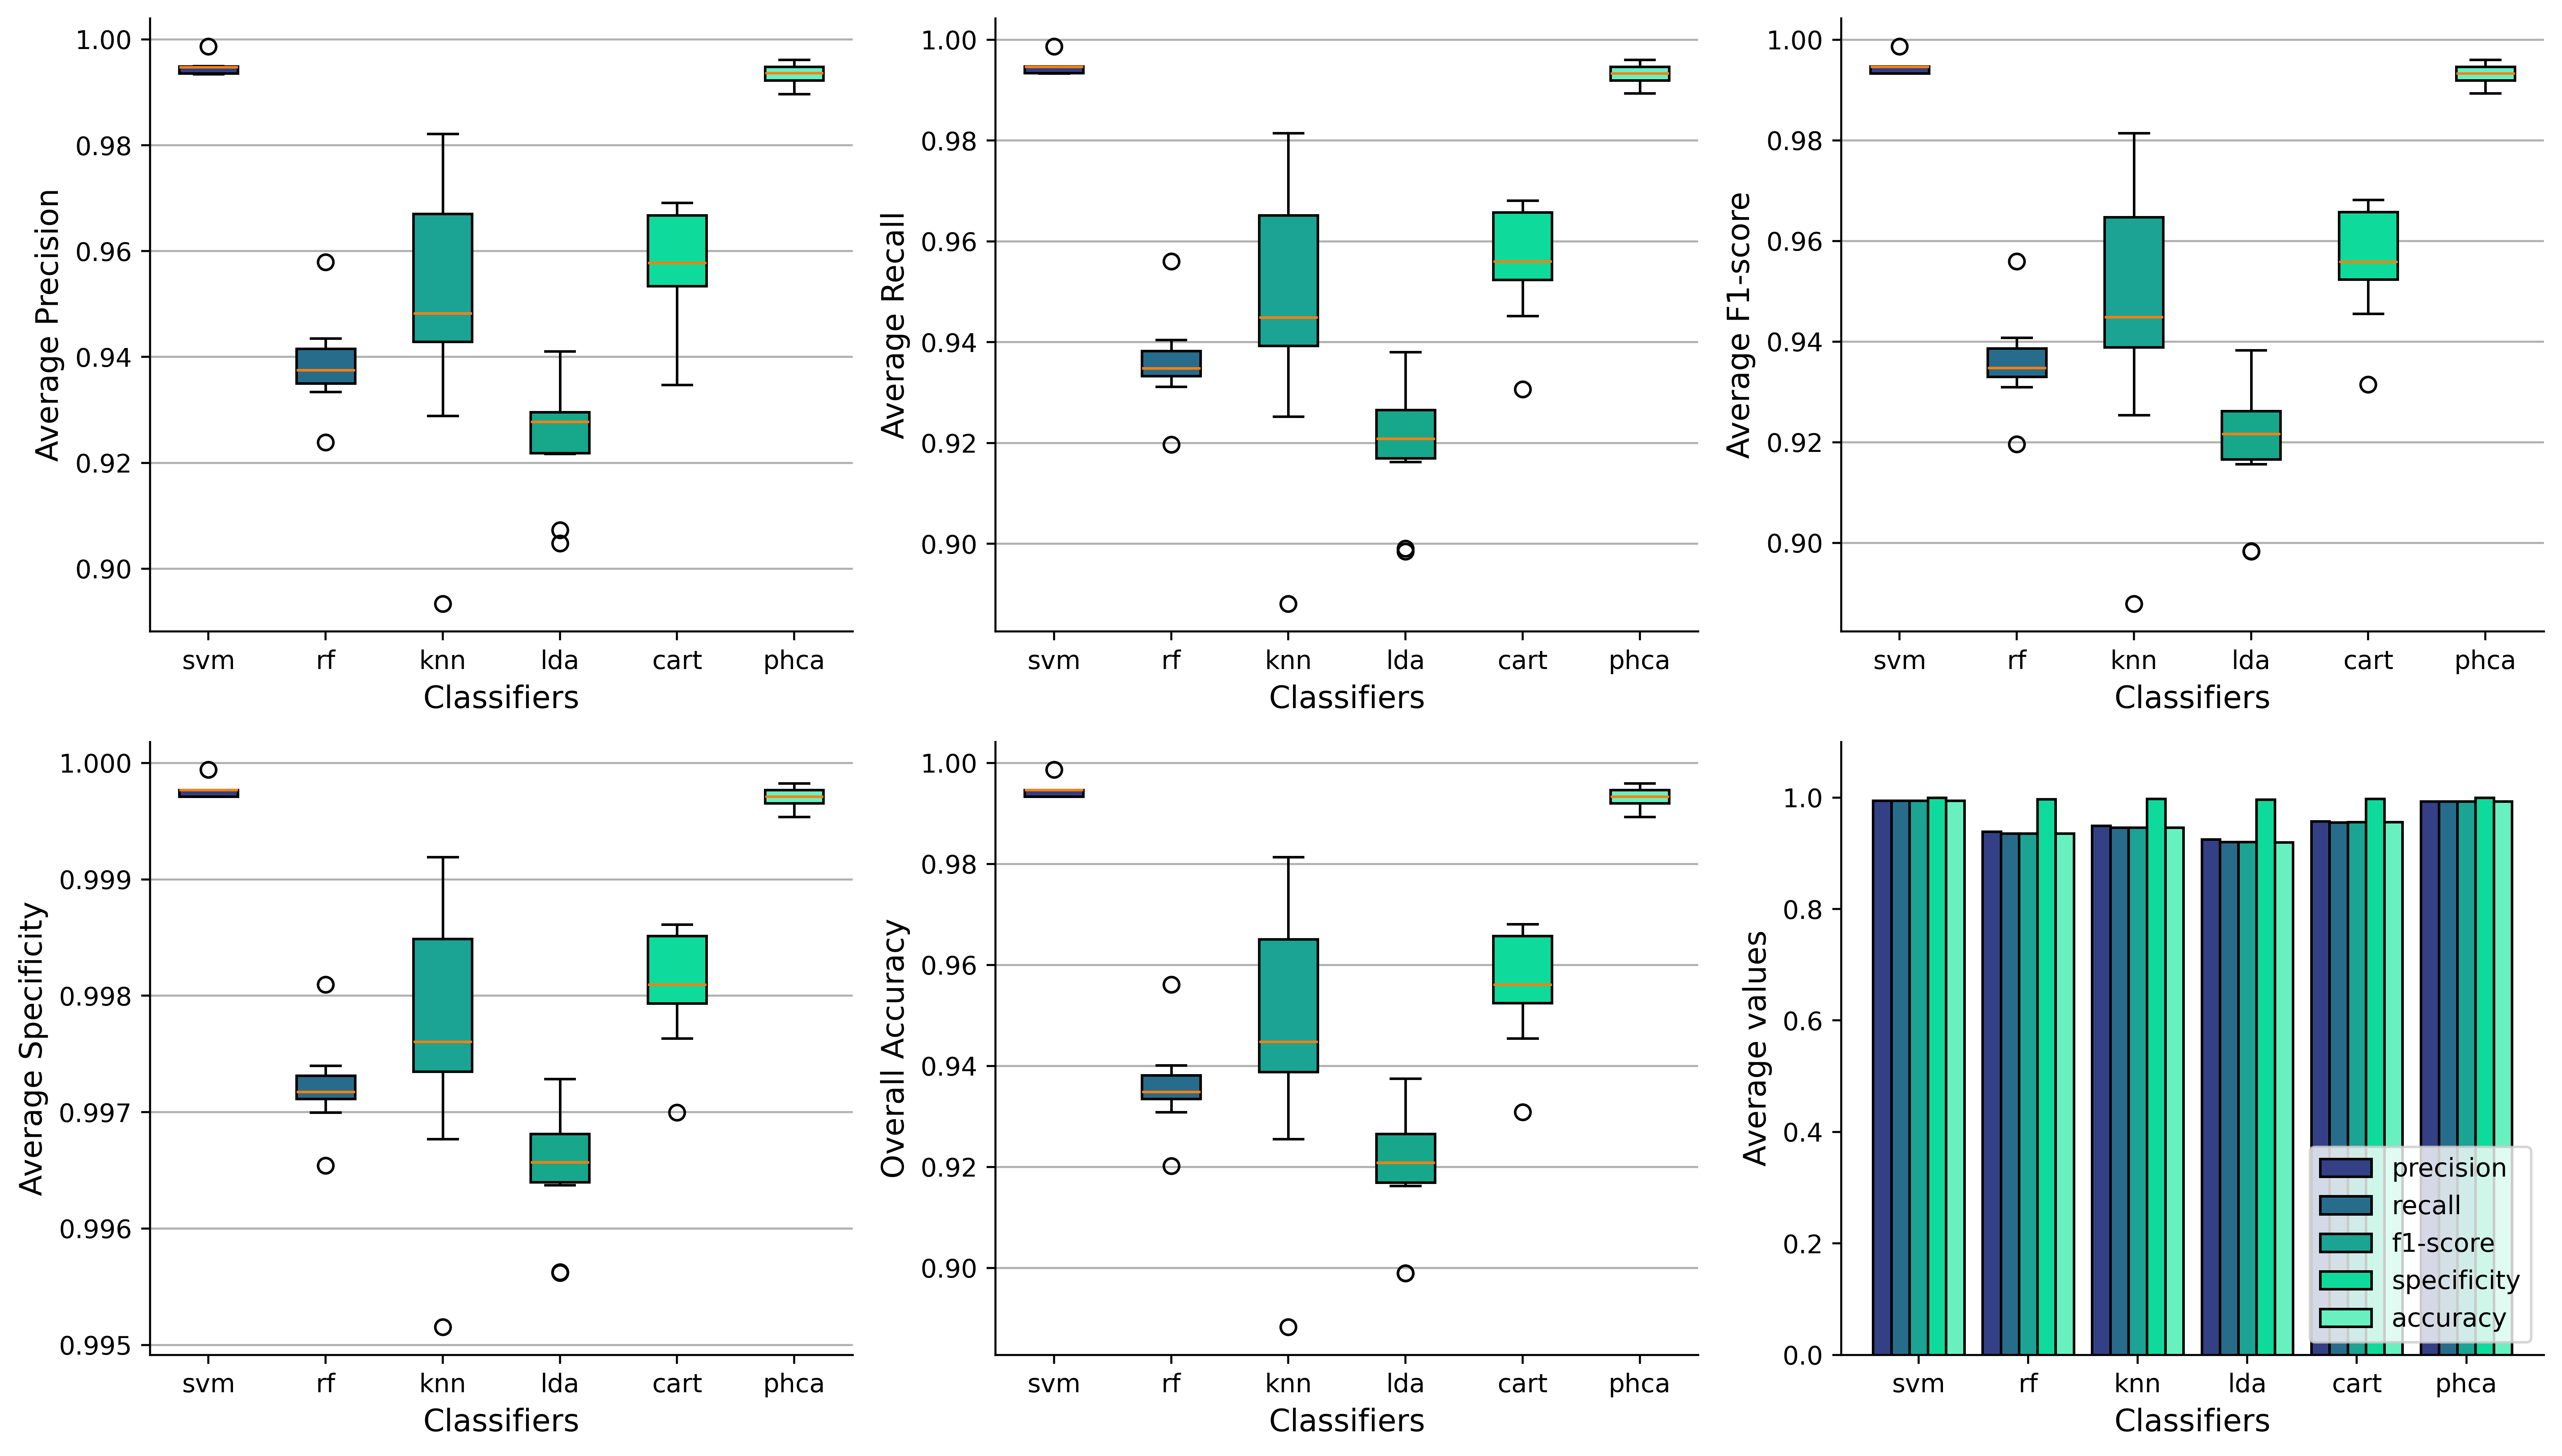

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
axs = axs.flatten()
metrics = ['precision', 'recall', 'f1-score', 'specificity', 'accuracy']

ave_scores = {met: [] for met in metrics}
for idx in range(len(metrics)):
    scores = plot_boxplots(predicted_labels_balanced, metrics[idx], ax=axs[idx])
    ave_scores[metrics[idx]] = scores.mean(axis=0)

plot_bars(ave_scores, metrics, ax=axs[-1])
# plt.suptitle("Classification Result for Balanced Dataset", fontsize=15)
plt.tight_layout()
if save_figs:
    plt.savefig("figures/mainresult_balanced.png")
plt.show()

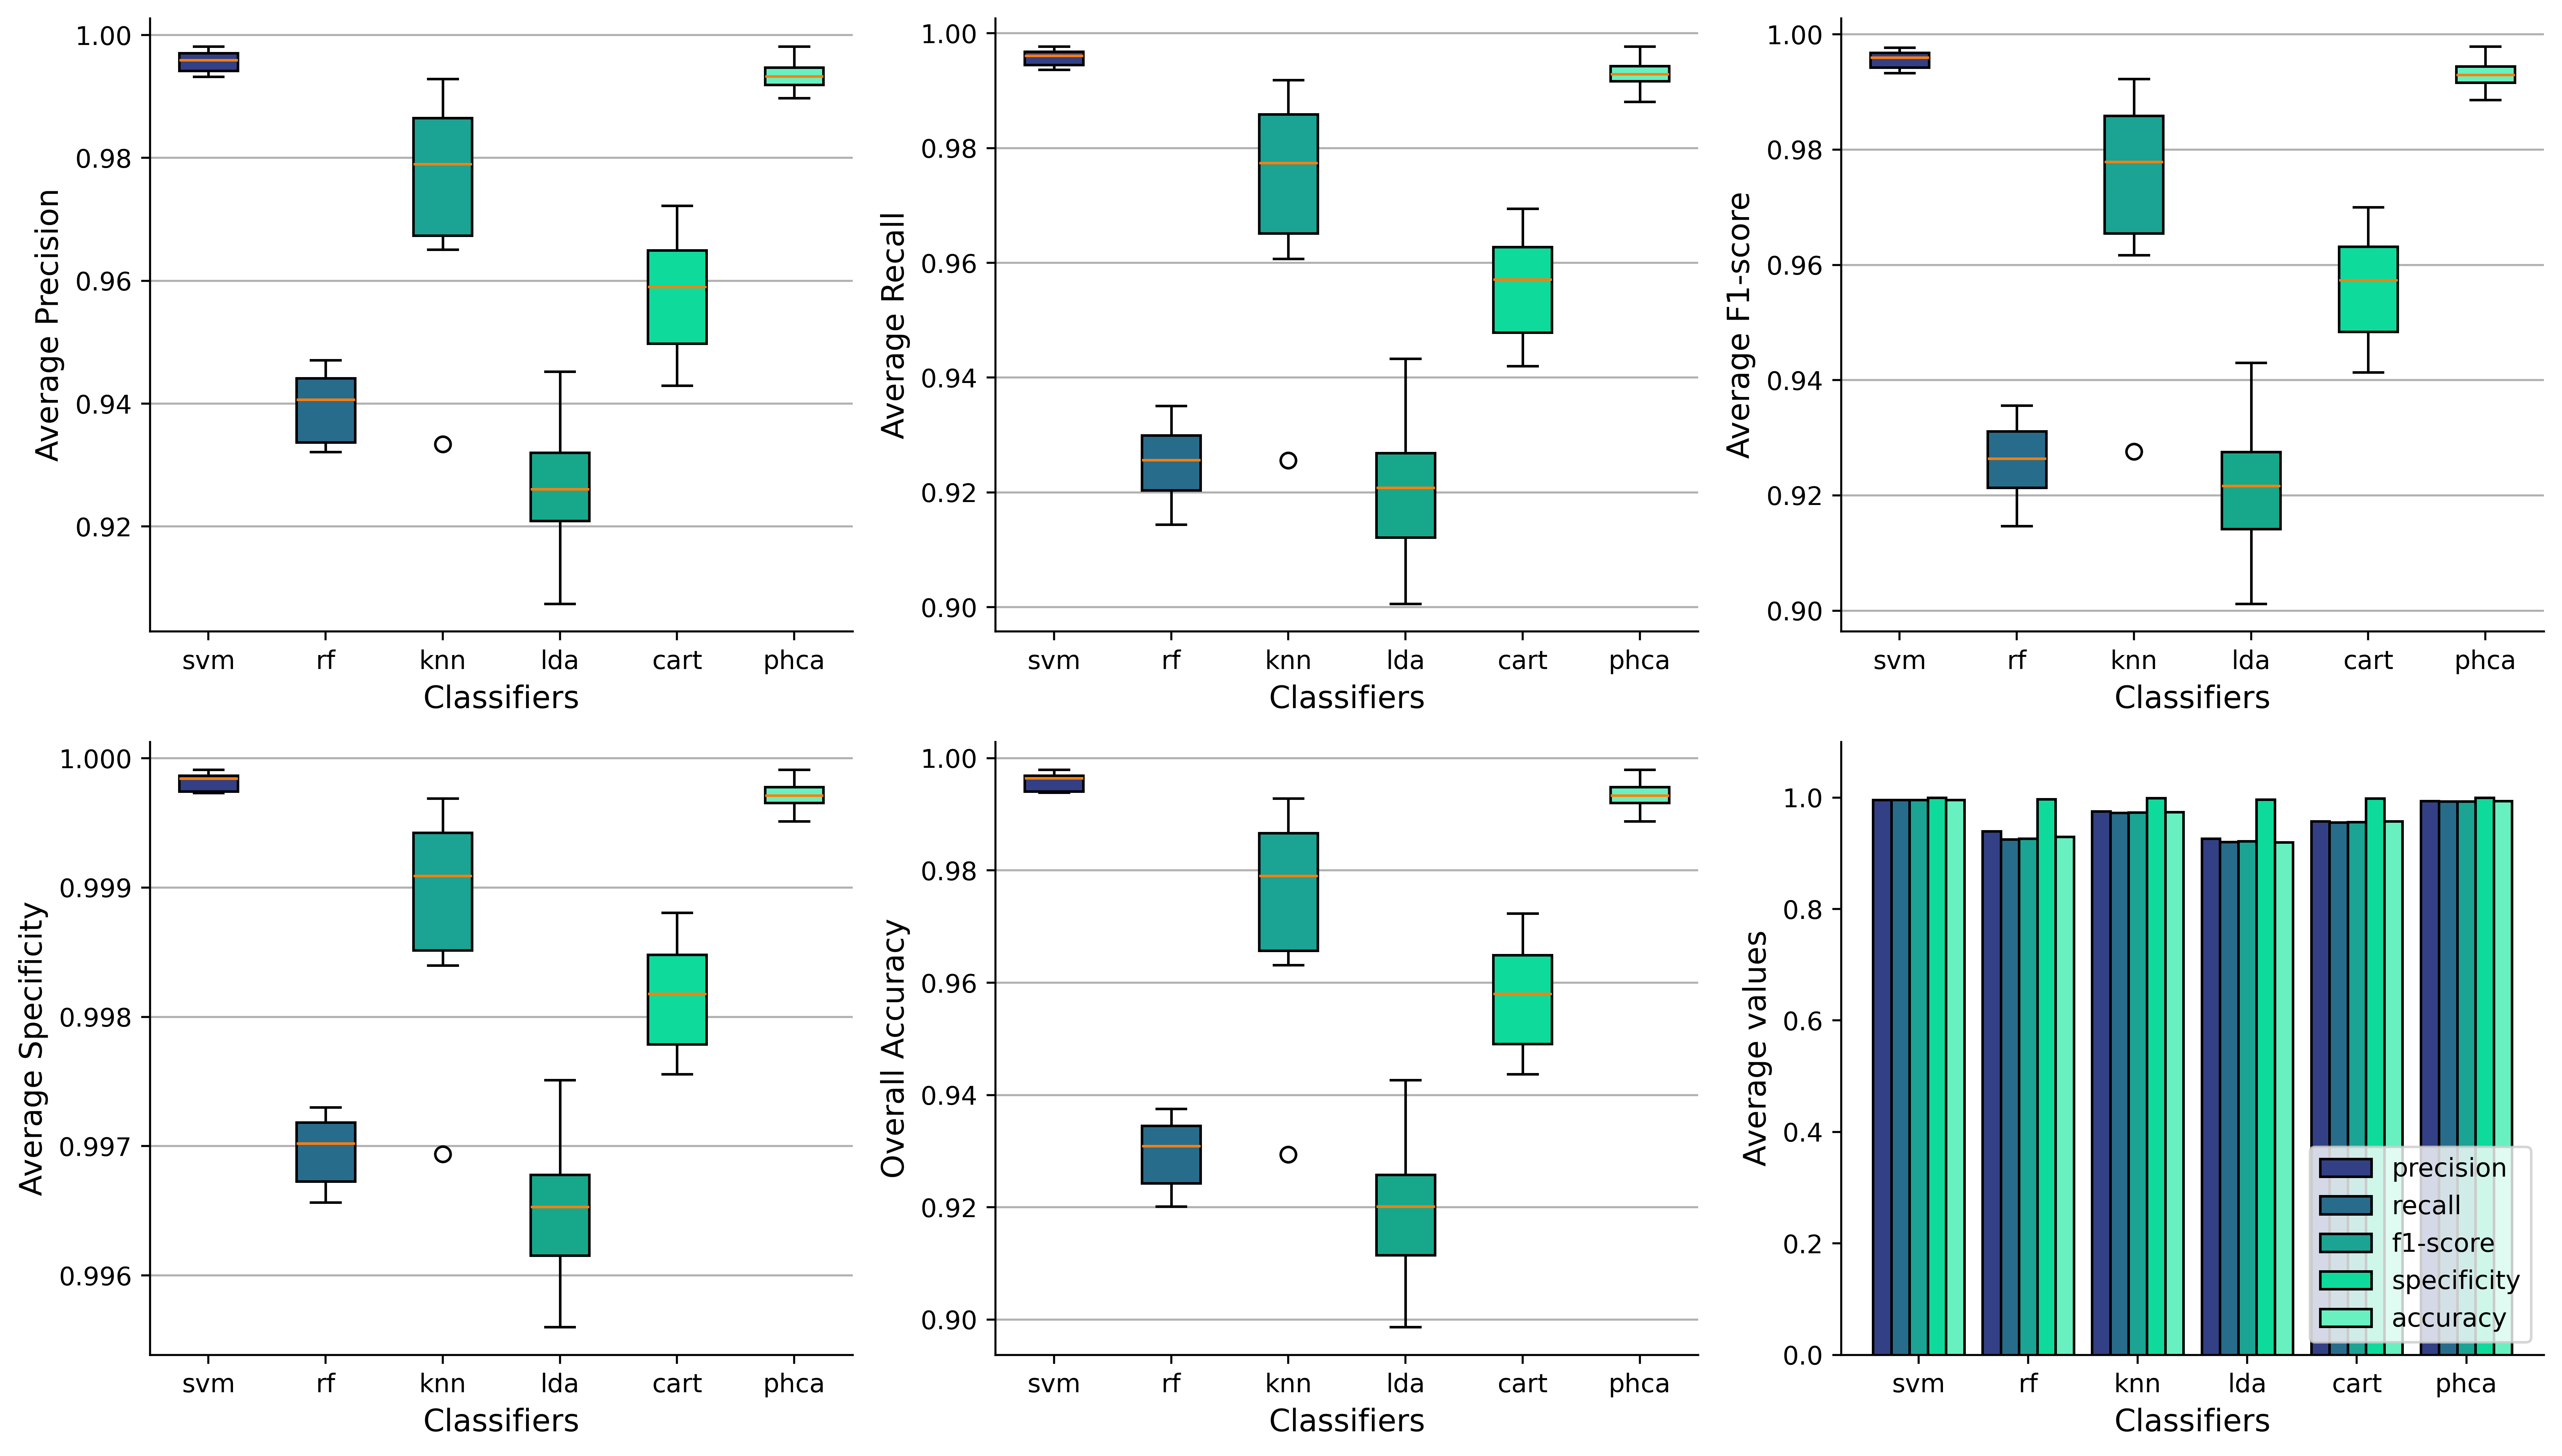

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
axs = axs.flatten()
metrics = ['precision', 'recall', 'f1-score', 'specificity', 'accuracy']

ave_scores = {met: [] for met in metrics}
for idx in range(len(metrics)):
    scores = plot_boxplots(predicted_labels_imbalanced, metrics[idx], ax=axs[idx])
    ave_scores[metrics[idx]] = scores.mean(axis=0)

plot_bars(ave_scores, metrics, ax=axs[-1])
# plt.suptitle("Classification Result for Imbalanced Dataset", fontsize=15)
plt.tight_layout()
if save_figs:
    plt.savefig("figures/mainresult_imbalanced.png")
plt.show()

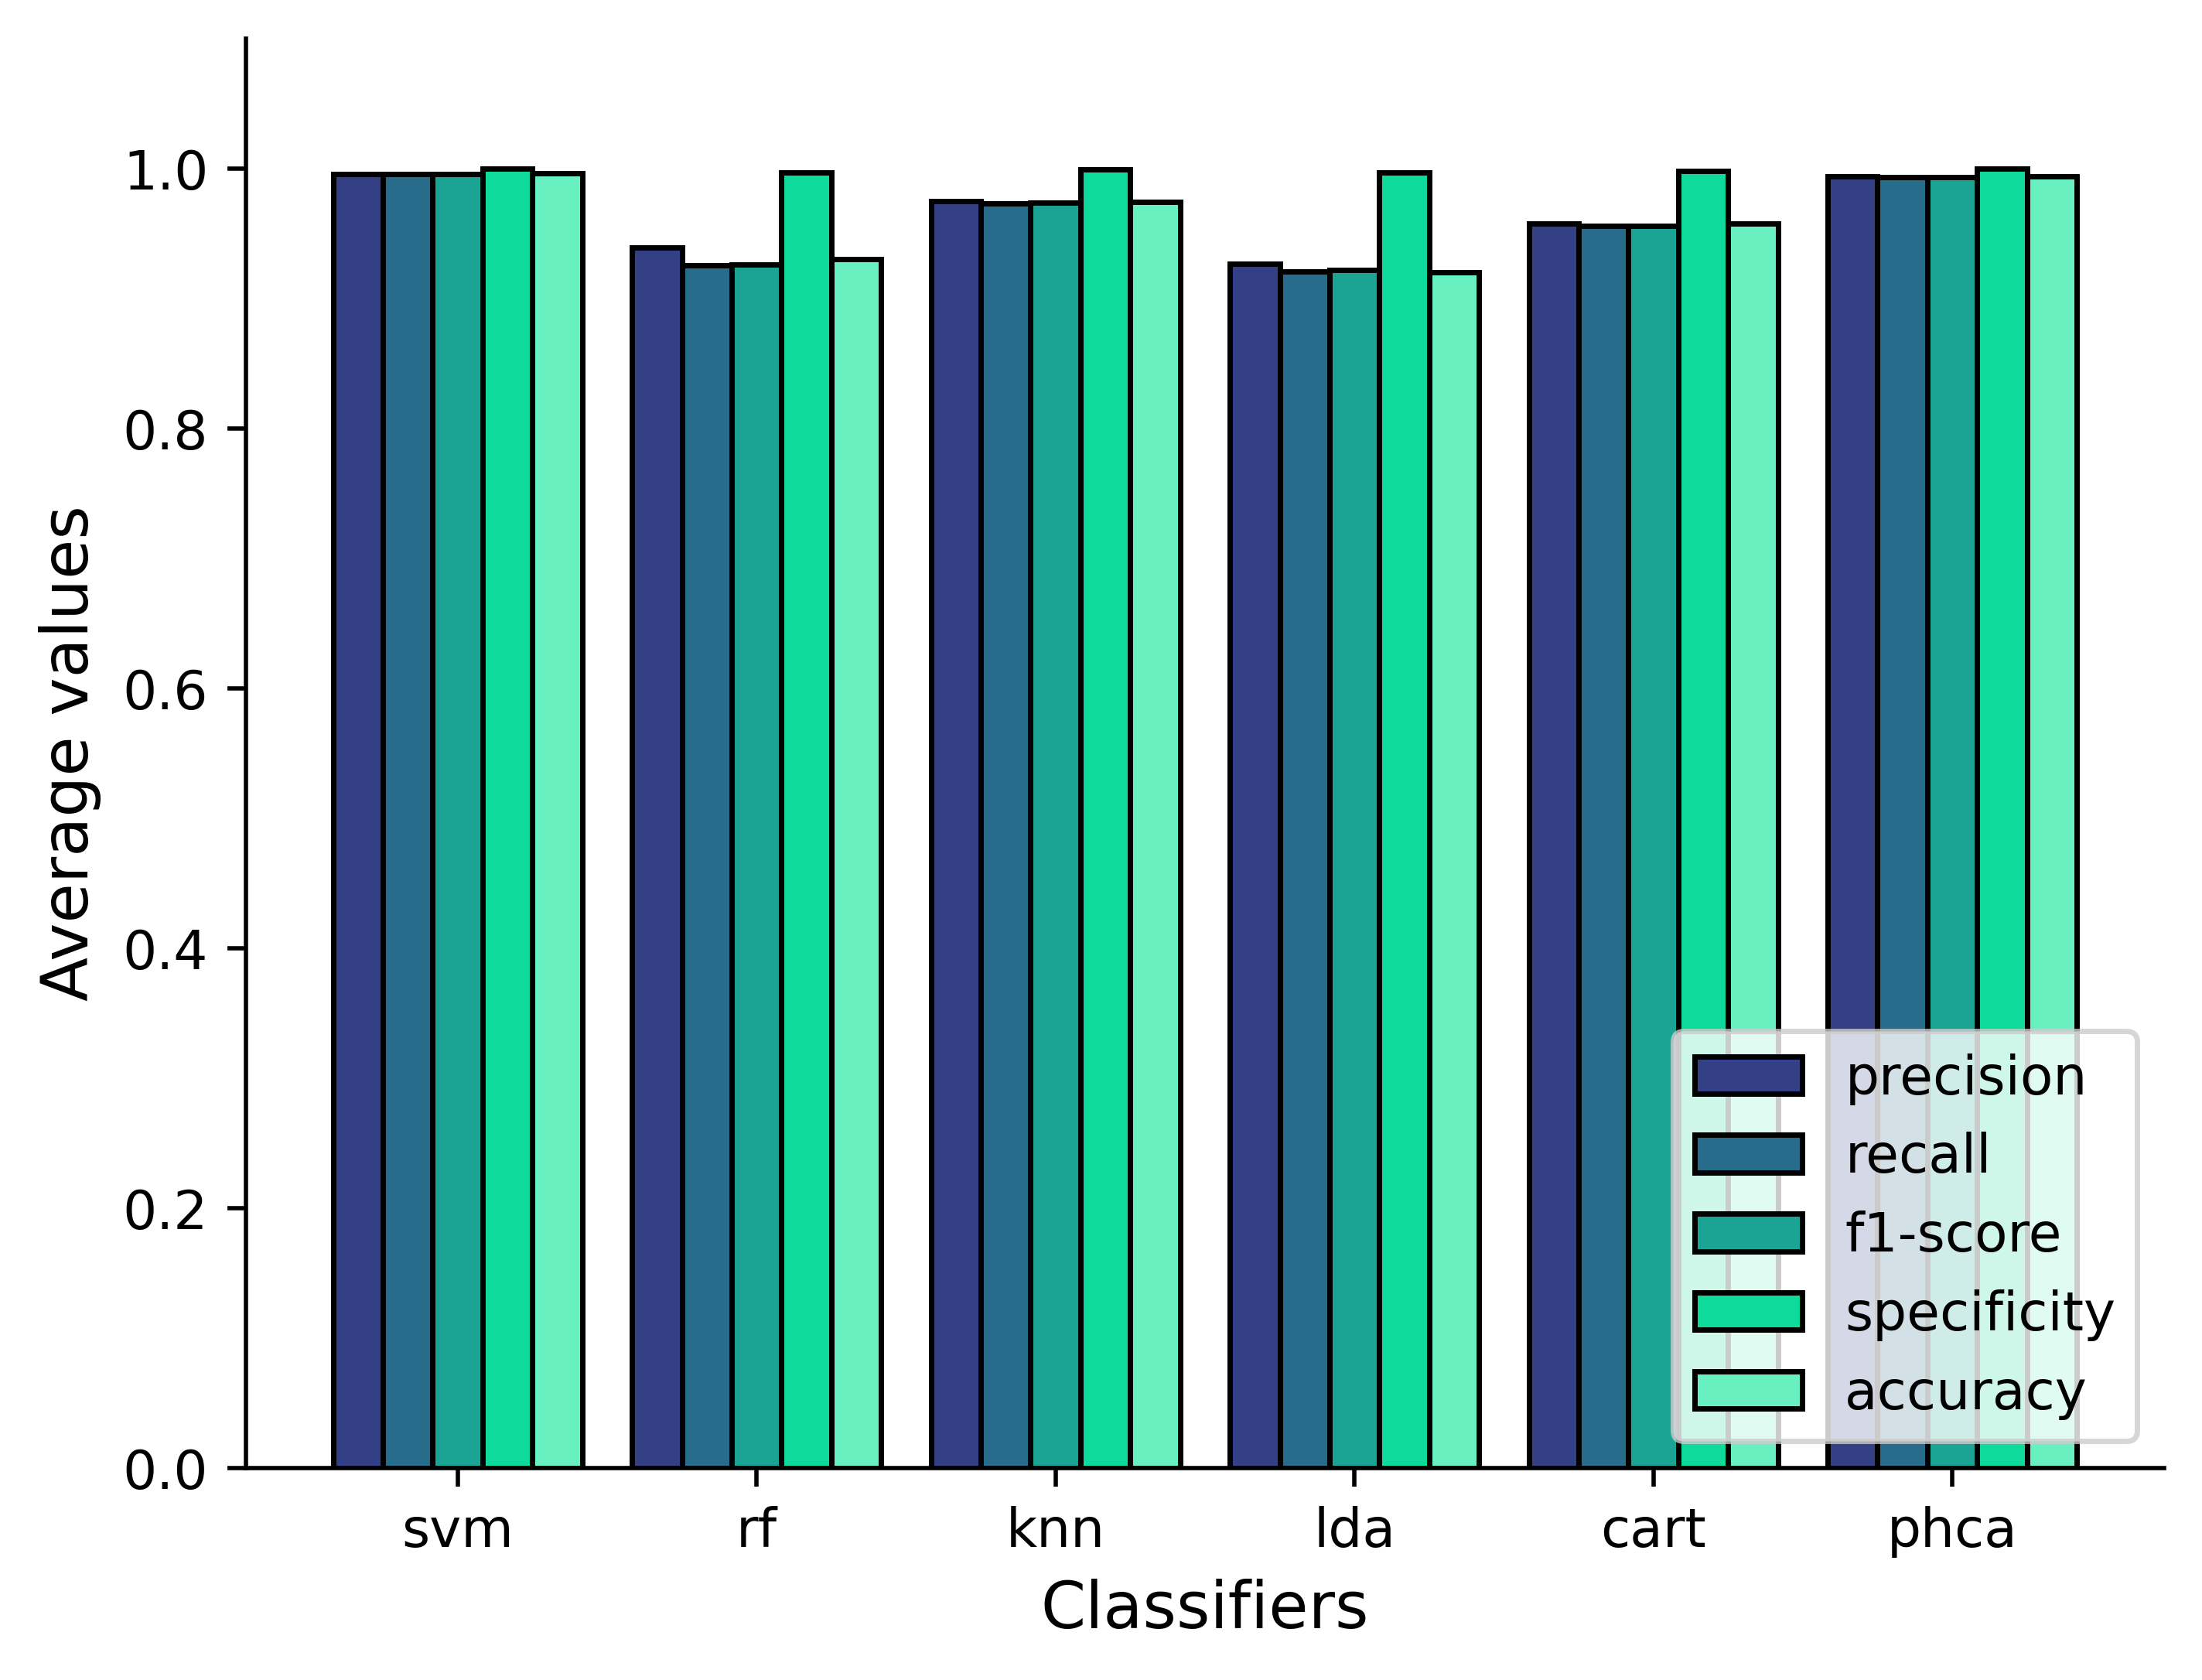

In [10]:
plot_bars(ave_scores, metrics)

#### Comparison of Evaluation Metrics

In [12]:
from modules import nemenyi_test

# plot controls
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12

predicted_labels_balanced = np.load("predicted_labels_balanced.npy", allow_pickle=True).item()
predicted_labels_imbalanced = np.load("predicted_labels_imbalanced.npy", allow_pickle=True).item()

metrics = ['precision', 'recall', 'f1-score', 'specificity', 'accuracy']
print("Predicted labels are extracted.")

Predicted labels are extracted.


In [13]:
nemenyi_result = nemenyi_test(predicted_labels_balanced, 5, metrics)

The p-value is: 4.2804424790612567e-29
At least one population mean differs from the others. 

           svm        rf       knn       lda      cart      phca
svm   1.000000  0.001000  0.001731  0.001000  0.001000  0.899439
rf    0.001000  1.000000  0.225773  0.464759  0.900000  0.001000
knn   0.001731  0.225773  1.000000  0.001000  0.184993  0.060387
lda   0.001000  0.464759  0.001000  1.000000  0.522633  0.001000
cart  0.001000  0.900000  0.184993  0.522633  1.000000  0.001000
phca  0.899439  0.001000  0.060387  0.001000  0.001000  1.000000


In [14]:
_ = nemenyi_test(predicted_labels_imbalanced, 8, metrics)

The p-value is: 6.195483465479254e-41
At least one population mean differs from the others. 

           svm     rf       knn    lda   cart      phca
svm   1.000000  0.001  0.666704  0.001  0.001  0.900000
rf    0.001000  1.000  0.001000  0.900  0.900  0.001000
knn   0.666704  0.001  1.000000  0.001  0.001  0.633456
lda   0.001000  0.900  0.001000  1.000  0.900  0.001000
cart  0.001000  0.900  0.001000  0.900  1.000  0.001000
phca  0.900000  0.001  0.633456  0.001  0.001  1.000000


#### Confusion Matrix of PHCA

In [15]:
from modules import plot_confusion_matrix

# plot controls
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12

predicted_labels_balanced = np.load("predicted_labels_balanced.npy", allow_pickle=True).item()
predicted_labels_imbalanced = np.load("predicted_labels_imbalanced.npy", allow_pickle=True).item()

In [16]:
# obtain best performing and least performing PHCA models (in terms of accuracy)
from sklearn.metrics import accuracy_score

def get_best_worst(predicted_labels:dict, model:str="phca") -> list:
    """ 
    Returns trial index that corresponds to best and worst
    accuracy obtained by the `model` 
    """
    n_trials = 10
    scores = []
    for i in range(n_trials):
        scores.append(accuracy_score(predicted_labels['true_labels'][i],
                                    predicted_labels[model][i]))
    return [np.argmax(scores), np.argmin(scores)], [np.max(scores), np.min(scores)]

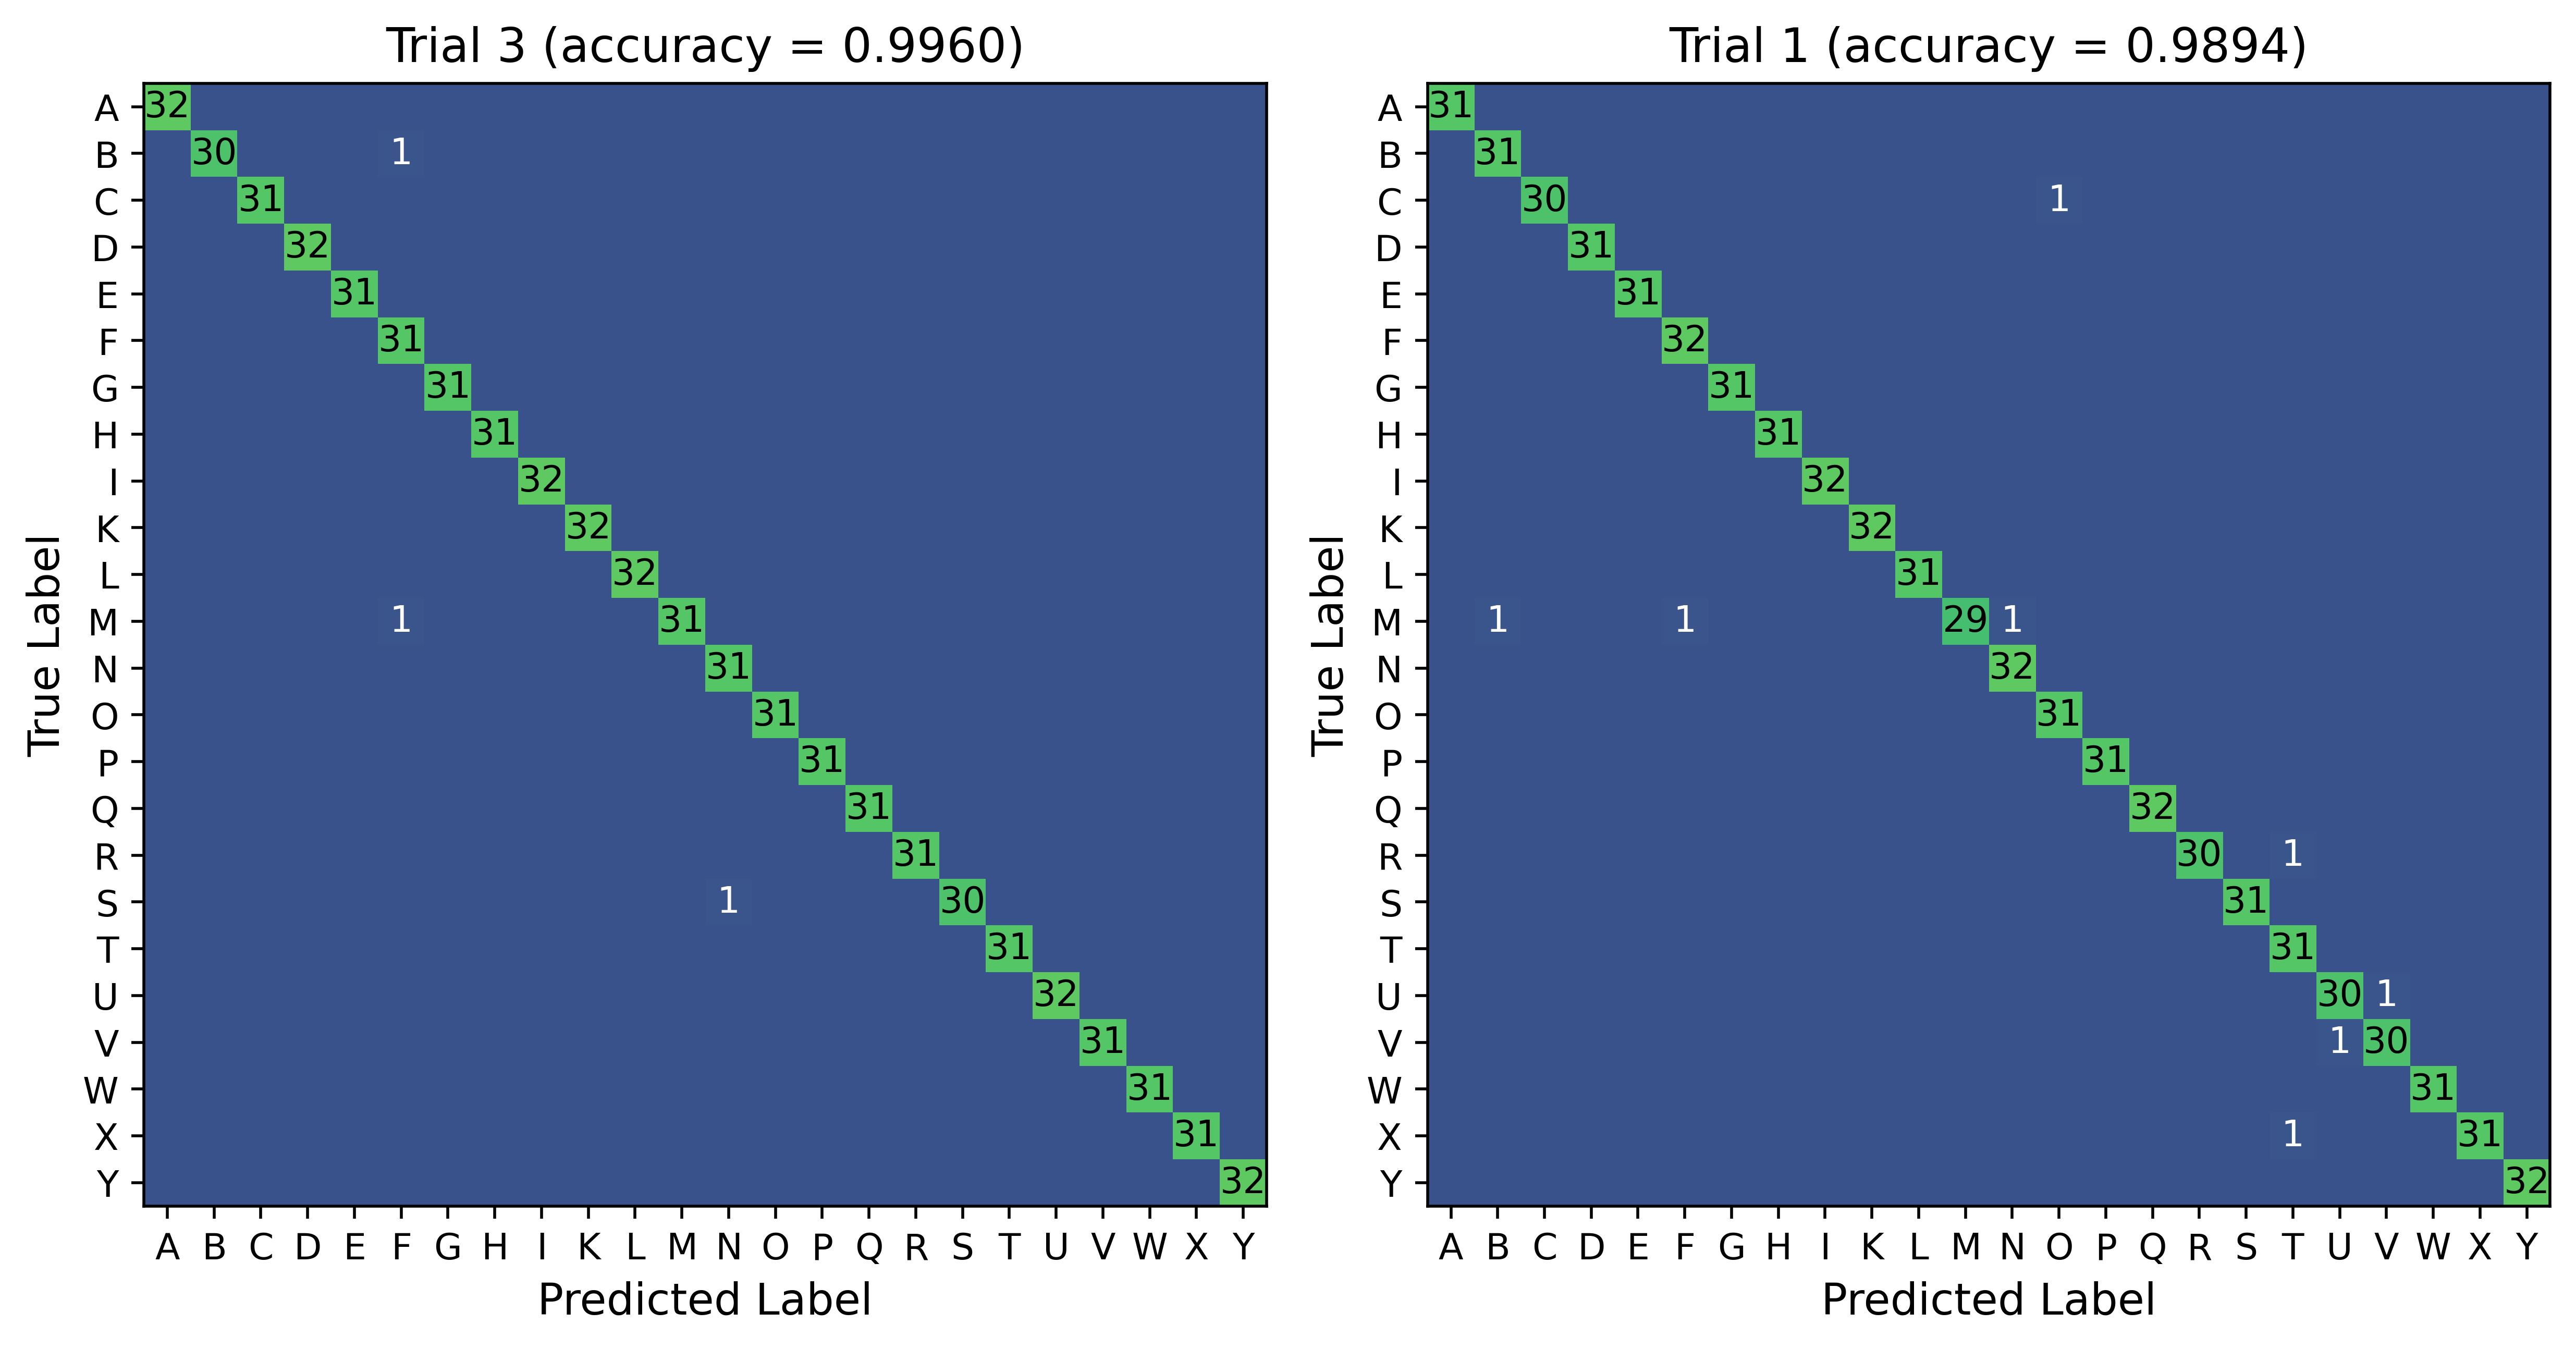

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = axs.flatten()

best_worst_idx, best_worst_scores = get_best_worst(predicted_labels_balanced)

for i, idx in enumerate(best_worst_idx):
    score = best_worst_scores[i]
    plot_confusion_matrix(predicted_labels_balanced, model='phca',
                          idx=idx, with_colorbar=False, ax=axs[i], title=f"Trial {idx+1} (accuracy = {score:0.4f})")

plt.tight_layout()
plt.show()

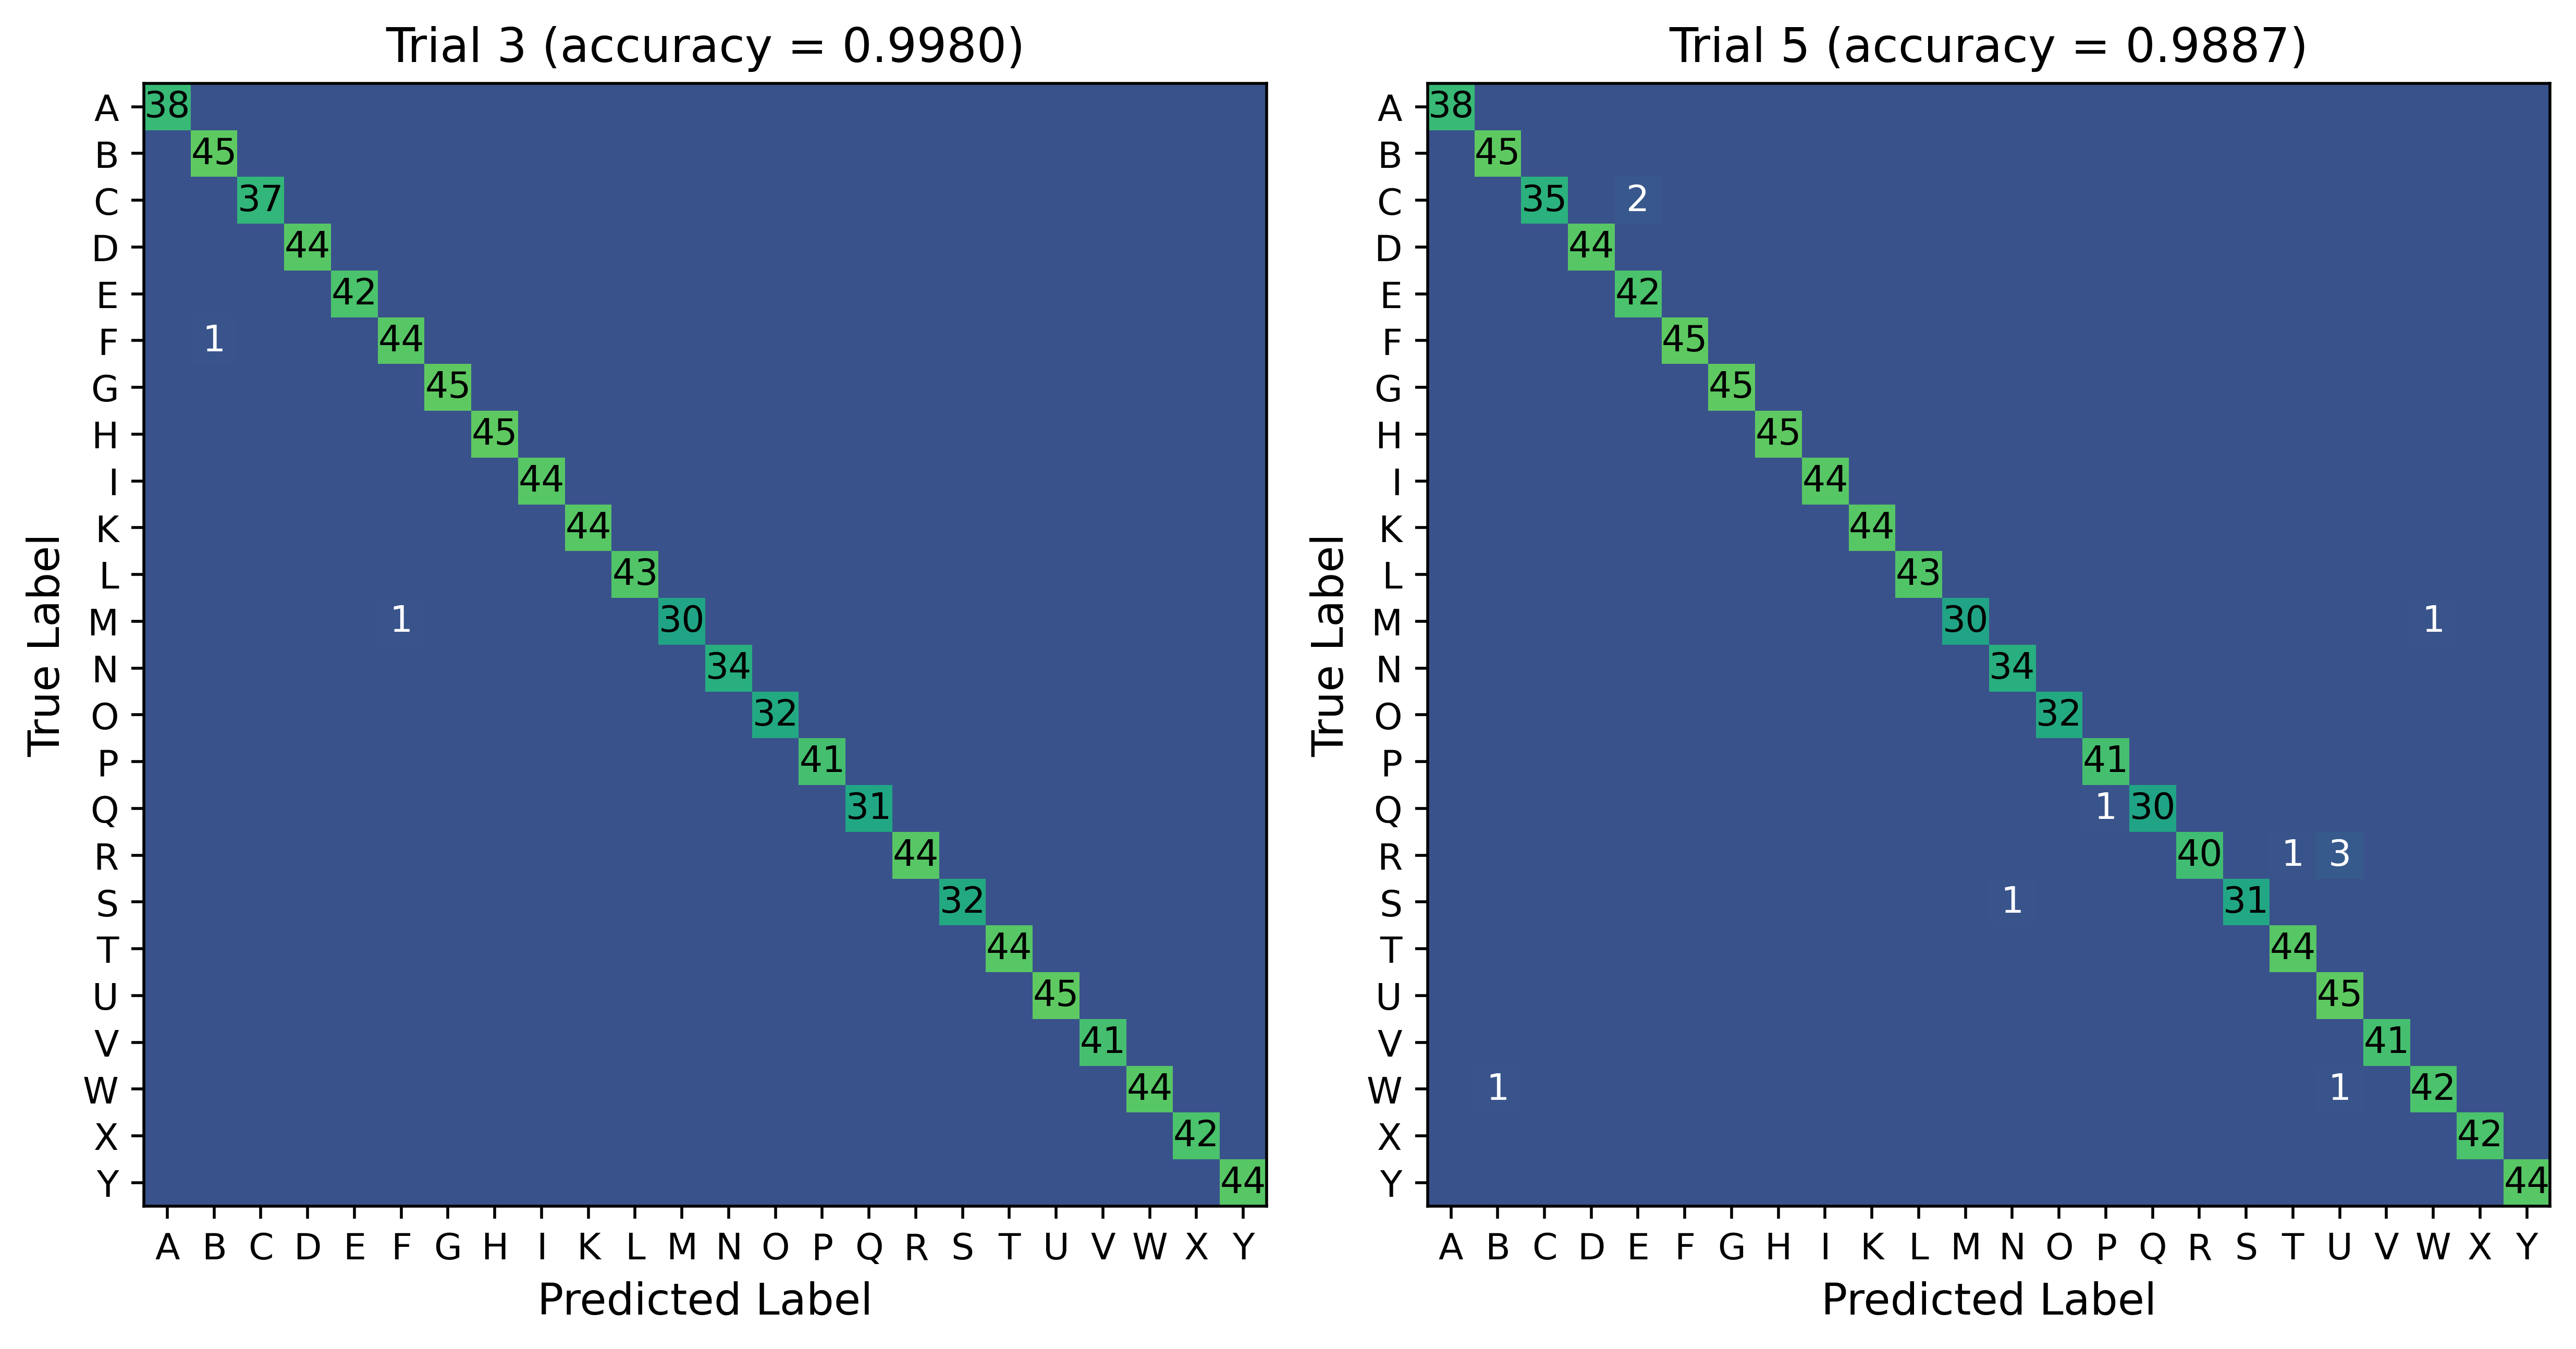

In [18]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = axs.flatten()

best_worst_idx, best_worst_scores = get_best_worst(predicted_labels_imbalanced)

for i, idx in enumerate(best_worst_idx):
    score = best_worst_scores[i]
    plot_confusion_matrix(predicted_labels_imbalanced, model='phca',
                          idx=idx, with_colorbar=False, ax=axs[i], title=f"Trial {idx+1} (accuracy = {score:0.4f})")

plt.tight_layout()
plt.show()

In [141]:
fig, axs = plt.subplots(2,5, figsize=(25,10))
axs = axs.flatten()

for i in range(len(axs)):
    plot_confusion_matrix(predicted_labels_balanced, model='phca',
                          idx=i, with_colorbar=False, ax=axs[i], title=f"Trial {i+1}")

plt.tight_layout()
plt.show()